# Lập trình Bootstrap với Python

## Bài 2: Ước lượng khoảng tin cậy

**BS. Lê Ngọc Khả Nhi**

# Dẫn nhập 

Đây là bài thứ 2 trong loạt bài về chuyên đề lập trình Bootstrap với ngôn ngữ Python. Trong bài trước, chúng ta đã biết khái quát về quy trình Bootstrap gồm 4 bước, và triển khai được bước thứ 1 - sinh mẫu ngẫu nhiên, bằng nhiều cách khác nhau. Hai bước tiếp theo trong quy trình này thực ra không mấy khó khăn (chỉ cần kĩ năng về vòng lặp và cập nhât giá trị trong 1 cấu trúc dữ liệu tùy chọn. Vấn đề đáng quan tâm hơn nằm ở bước sau cùng - suy diễn thống kê, cũng chính là kết quả của phân tích bootstrap. Trong bài hôm nay, Nhi sẽ giới thiệu về một trong những kỹ thuật suy diễn thống kê, đó là khoảng tin cậy, dưa vào phân vị của chuỗi thông số thống kê.

In [2]:
from typing import List

# CPU
import numpy as np
import pandas as pd
import math

# GPU (nếu có)
import cupy as cp
import torch

# Đồ họa
import matplotlib.pyplot as plt
import seaborn as sns

# Bài toán minh họa

Một bác sĩ khảo sát chỉ số DLCO (lưu lượng khuếch tán khí CO) ở 133 bệnh nhân bệnh phổi mô kẽ (ILD). Ta tạo ra 1 numpy array chứa dữ liệu này như bên dưới:

In [3]:
# Tải dữ liệu 

path = 'https://raw.githubusercontent.com/kinokoberuji/Statistics-Python-Tutorials/master/Schleroderma.csv'
df = pd.read_csv(path, sep = ';', decimal = ',')

sample_dlco = df[df['ILD'] == 'Positive']['DLCO'].values

print(sample_dlco.size)
sample_dlco[:10]

133


array([11.73, 16.75, 10.59,  8.64, 20.15,  8.43, 12.04, 13.37, 13.4 ,
       14.9 ])

# Trung bình của mẫu và của quần thể


Thuật ngữ thống kê gọi đây là 1 mẫu quan sát (sample), bất cứ thông số thống kê nào được ước tính trên dữ liệu này mang ý nghĩa xác định, nhưng cá biệt/cục bộ cho riêng mẫu khảo sát hiện tại. 

Thí dụ trung bình của DLCO trong mẫu 133 bệnh nhân này là 13.55;

In [4]:
# Giá trị DLCO trung bình của bệnh nhân  xơ phổi là bao nhiêu ?

sample_dlco.mean()

13.55488721804511

Nếu ta lặp lại thí nghiệm khác, tại một bệnh viện/thành phố khác, ta sẽ có một mẫu khác, và thu được một giá trị trung bình khác với giá trị hiện thời, thí dụ nó có thể là 12.5 hoặc 14.0.

Do ở bất cứ thời diểm nào, ta không bao giờ có được dữ liệu cho tất cả bệnh nhân ILD toàn nhân loại, và qua mọi thời đại (bao gồm tương lai), nên giá trị trung bình DLCO cho quần thể bệnh nhân ILD mãi mãi là một ẩn số mà ta không bao giờ biết được.

Như vậy, nếu chỉ báo cáo duy nhất giá trị trung bình của mẫu là không đủ, ta cần một thông tin khác: tương ứng với mẫu khảo sát này, những giá trị tiềm tàng của trung bình quần thể có thể là bao nhiêu ? Thông tin này là khoảng tin cậy (KTC)


# Giới thiệu về khái niệm khoảng tin cậy

Khoảng tin cậy (Confidence interval, CI) là một loại ước lượng thống kê dạng khoảng, áp dụng trên một **mẫu** quan sát, nhằm cung cấp một khoảng giá trị tiềm tàng của một thông số chưa được biết (thí dụ: trung bình của **quần thể**), với một mức độ tin cậy định trước (thí dụ: 90%, 95%, 97.5% hoặc 99%). Hình thức phổ biến nhất thường dùng để báo cáo kết quả trong y văn là KTC 95%.

Lý thuyết về KTC được đề xuất từ năm 1937 bởi nhà thống kê Jerzy Neyman (1894 – 1981), tuy nhiên phải mất một thời gian khá dài khái niệm này mới được chấp nhận, hiểu chính xác và áp dụng thường quy.

Ngay cả khi ta hiểu mục tiêu cần tìm - khoảng tin cậy; câu hỏi tiếp theo sẽ là: phải làm cách nào để có khoảng tin cậy ? Chúng ta đang ở ngay trên con đường dẫn tới kết quả này, đó là Bootstrap ! Bootstrap là giải pháp giúp ta ước tính được khoảng tin cậy.

Như ta đã biết: Kết quả sau bước 2 và bước 3 của quy trình Bootstrap cho chúng ta 1 tập hợp rất nhiều (hàng ngàn) giá trị của thông số thống kê mục tiêu (thí dụ trung bình) tương ứng với từng ấy mẫu khảo sát được rút ra ngẫu nhiên từ dữ liệu gốc.
Ta có thể ước tính khoảng tin cậy dựa vào các phân vị trong chuỗi giá trị này. Thí dụ: phân vị 0.025 và 0.975

Nếu không dùng bootstrap, ta cần phải tiến hành chọn mẫu và thí nghiệm hàng ngàn lần trên thực tế - như vậy Bootstrap khiến cho bài toán ước lượng khoảng tin cậy trở nên khả thi và dễ dàng hơn rất nhiều.

# KTC như phân vị của kết quả bootstrap

Nhi viết 1 hàm basic_boot_mean triển khai 3 bước trong quy trình bootstrap để ước lượng trung bình cho mẫu dữ liệu DLCO hiện thời, hàm này hoàn sử dụng numpy: np.choice để sinh mẫu ngẫu nhiên, np.array để làm place holder, và method mean cũng của numpy...
(Giải pháp khác hoàn toàn chạy trên GPU sẽ được trình bày ở phần sau).

Nhi dùng hàm này để tạo ra 1 array means chứa 5000 giá trị trung bình khác nhau...

In [8]:
# Chọn mẫu ngẫu nhiên có hoàn lại, x 5000 lần rồi ước tính trung bình

def basic_boot_mean(data, n_iter = 5000):
    
    b_means = np.zeros(n_iter)
    k = b_means.size

    for i in range(k):

        boot_sampl = np.random.choice(data,
                                      size = k, 
                                      replace=True)

        b_means[i] = boot_sampl.mean()
        
    return b_means

In [9]:
means = basic_boot_mean(sample_dlco, n_iter = 5000)

In [10]:
print(means.size)
means[:10]

5000


array([13.582304, 13.569628, 13.444738, 13.57842 , 13.581826, 13.583772,
       13.50949 , 13.498252, 13.444792, 13.489774])

# Cách ước tính phân vị

Như đã trình bày ở trên, với bootstrap ta chuyển vấn đề ước tính khoảng tin cậy của giá trị trung bình (sample mean) thành bài toán ước tính các phân vị (quantiles) của array means chứa 5000 giá trị trung bình. Phần tiếp theo của bài thực hành sẽ tập trung giải quyết bài toán này. 

## Lập trình sơ cấp trong Python

Ước tính phân vị là một thuật toán thống kê tương đối đơn giản, ta có thể code nó hoàn toàn thủ công chỉ dùng Python, không cần thư viện nào khác. 

Tuy nhiên, thuật toán này yêu cầu array means phải được sắp xếp thứ tự tăng dần. Nhi từng có một bài viết về chủ đề này : https://nbviewer.jupyter.org/github/kinokoberuji/Python-snipets/blob/master/Sorting%20algorithms.ipynb; trong bài thực hành hôm nay, Nhi sẽ áp dụng algorithm Heap sort chưa có trong bài trước; vì algorithm này có hiệu năng rất ổn định về tốc độ thi hành (trung bình là O(n.log(n)).

In [11]:
# Quy trình Heap-sort

def heapify(array, n, i):
    """Hàm chuyển array thành Heap"""
    largest = i
    l = 2 * i + 1
    r = 2 * i + 2
    
    if l < n and array[i] < array[l]:
        largest = l
        
    if r < n and array[largest] < array[r]:
        largest = r
        
    if largest != i:
        array[i], array[largest] = array[largest], array[i]
        heapify(array, n, largest)

def heapSort(array):
    """Hàm thực hiện Heap sort"""
    n = len(array)

    for i in range(n, -1, -1):
        heapify(array, n, i)

    for i in range(n-1, 0, -1):
        array[i], array[0] = array[0], array[i]
        heapify(array, i, 0)

    return array

Tiếp theo, Nhi viết 2 hàm basic_quantile và basic_quantiles, cho phép ước tính tất cả phân vị trong khoảng từ 0 đến 1; trên thực tế ta chỉ cần 2 vị trí là 0.025 và 0.975 để xác định 95%CI

In [12]:
def basic_quantile(data, p:float):

    assert 0 <= p <= 1, "Lỗi: Phân vị phải nằm trong khoảng [0-1]"
    
    loc = (len(data) - 1) * p

    lower = math.floor(loc)
    d0 = data[lower] * ((lower + 1) - loc)
    d1 = data[lower + 1] * (loc - lower)
        
    return d0 + d1

def basic_quantiles(data, q = [0.025,0.975]):
    
    data = heapSort(data)
    # quantiles = np.empty(len(q)) # Nếu dùng numpy array
    quantiles = ['NA']*len(q)  # Dùng Python list
    
    for i in range(len(q)):
        try:
            quantiles[i] = basic_quantile(data, q[i])
        except:
            continue
    
    return quantiles

Nhi test hàm này trên array means và 5 giá trị phân vị [0.025,0.1,0.5,0.9,0.975]

In [13]:
q5 = basic_quantiles(means, q=[0.025,0.1,0.5,0.9,0.975])

q5

[13.41920775, 13.465877800000001, 13.55425, 13.641552200000003, 13.6864525]

Nhi lại viết 1 hàm ci_plot để biểu diễn trực quan đặc tính phân phối của array means, kèm theo trung vị, phân vị 0.025 và 0.975:

In [177]:
def ci_plot(data, q = [2.5,97.5]):
    
    plt.rcParams["figure.figsize"] = [6,3]
    
    xs = [np.median(data)] + list(np.quantile(data, q))
    
    fig = sns.kdeplot(data, 
                shade = True, 
                color='#b5db2a', 
                alpha = 0.7)
    
    yb = fig.get_ybound()
    
    for v in xs:
        plt.vlines(x=v,
                   ymin = yb[0],
                   ymax = yb[1]-yb[1]/10,
                   color = 'k',
                   alpha = 0.8,
                   linestyles = 'dashed',
                   lw=1.2)
        
        plt.text(v,
                 yb[1]-yb[1]/10,
                 f"{v:.3f}",
                 size=10, 
                 alpha = 1,
                 rotation=45,
                 ha="center", 
                 va="center",
                 bbox=dict(boxstyle="round",
                           alpha = 0.7,
                           fc='gold'))
    
    plt.ylim(0,yb[1] + yb[1]/5)
    plt.show()

Đây là kết quả của hàm này cho danh sách phân vị [0.025,0.1,0.5,0.9,0.975];

Ta có thể nhận ra 1 điều thú vị, đó là kết quả boostrap 5000 lượt giá trị trung bình tạo ra một phân phối xấp xỉ phân phối chuẩn (Gaussian); đây là điều kì diệu của tạo hóa: Khi thêm bớt, xê dịch 1 lượng ngẫu nhiên từ một vị trí ban đầu, và lặp lại rất nhiều lần, ta sẽ tạo ra phân phối Chuẩn !

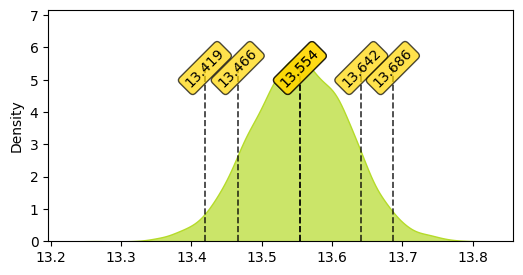

In [205]:
ci_plot(means, [0.025,0.1,0.5,0.9,0.975])

## Sử dụng numpy

Ta vừa code thủ công hàm tính phân vị của 1 array (cũng chính là ước tính khoảng tin cậy 95% của sample mean !). Trên thực tế, chúng ta có thể dùng những thư viện cấp cao như method numpy.quantile(), như sau:

In [24]:
np.quantile(means, [0.025,0.975])

array([13.41920775, 13.6864525 ])

Kết quả này hoàn toàn giống như kết quả hàm thủ công ở trên; như vậy ta có thể xác định KTC95% của giá trị DLCo trung bình trong mẫu này là [13.42 - 13.69]

## Sử dụng pandas

Khi sử dụng pandas, ta có method describe, nó sẽ làm một thống kê mô tả rất chi tiết, bao gồm trung bình, SD, min, max, bách phân vị 50 (trung vị) và bất cứ phân vị nào ta chọn. 

Nhi chỉ trích riêng 3 phân vị 0.025, trung vị và 0.975 như sau:

In [58]:
def pd_quantiles(data: np.array, q = [0.025,0.975]):
    
    desc = pd.Series(data).describe(percentiles = q)
    return desc.iloc[4:-1]

In [59]:
pd_quantiles(data = means, q = [0.025,0.975])

2.5%     13.419208
50%      13.554250
97.5%    13.686452
dtype: float64

Phần tiếp theo chạy trên GPU, nếu máy tính của bạn không có GPU có thể bỏ qua đoạn này; nhưng nếu có, mời bạn đọc tiếp. Tốc độ tính toán trên GPU sẽ cực kì nhanh.

Nhi sẽ triển khai 2 quy trình bootstrap giá trị trung bình dùng Pytorch và CUPY


# Sử dụng GPU

## Pytorch

Sau đây là quy trình bootstrap đủ 4 bước sử dụng Pytorch tensor:

In [170]:
def torch_boot_idx(pop_size, num_samples):
        p = torch.ones(pop_size, device='cuda') / pop_size
        return p.multinomial(num_samples=num_samples, replacement=True)

def torch_boot_mean(data, n_iter = 5000):
    
    k = data.size
    
    torch_x = torch.tensor(data, 
                           device = 'cuda', 
                           dtype = torch.float32)
    
    tor_b_means = torch.zeros(size = (n_iter,), 
                              device = 'cuda', 
                              dtype = torch.float32)
    
    for i in range(n_iter):
            
        tor_idx = torch_boot_idx(pop_size = k, 
                             num_samples = k)
        
        tor_sample = torch_x[tor_idx]
        theta = tor_sample.mean()
        
        tor_b_means[torch.tensor(i)] = theta.item()
        
    return tor_b_means

def tor_quantiles(data, q = [0.025, 0.975]):
    
    tor_quants = [data.quantile(i).item() for i in q]
    
    return tor_quants

Do ta đã tái chọn mẫu lại từ đầu, nên kết quả của quy trình này không bắt buộc phải giống như kết quả chạy trên CPU (tensor means không còn như cũ nữa).

Theo quy trình này, KTC 95% của trung bình là [12.78 - 14.41]

In [161]:
boot_mean_tensor = torch_boot_mean(data = sample_dlco, n_iter = 5000)

In [171]:
tor_quantiles(boot_mean_tensor, q = [0.025, 0.975])

[12.77697467803955, 14.412757873535156]

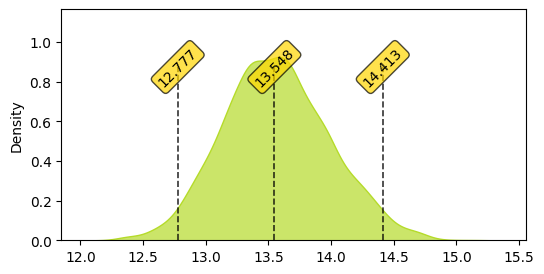

In [179]:
ci_plot(boot_mean_tensor.cpu().numpy(), [0.025,0.975])

## CUPY

Nếu bạn thấy việc code bằng pytorch quá khó khăn, ta có 1 giải pháp khác dễ chịu hơn rất nhiều, đó là CUPY, vì cú pháp của CUPY hoàn toàn giống như numpy, chỉ khác về tốc độ tính toán nhanh hơn khi sử dụng GPU.

Sau đây là quy trình bootstrap mean sử dụng CUPY

In [188]:
def cupy_boot_mean(data, n_iter = 5000):
    
    k = data.size
    gpu_arr = cp.asarray(data, dtype='float32')
    
    cupy_b_means = cp.zeros(n_iter, dtype='float32')
    
    for i in range(n_iter):
        
        cupy_samp = cp.random.choice(gpu_arr, 
                                     size=k, 
                                     replace=True)
        
        cupy_b_means[i] = cp.mean(cupy_samp)
    
    return cupy_b_means

In [191]:
cp_boot_means = cupy_boot_mean(sample_dlco, n_iter = 5000)

cp_boot_means

array([13.357368 , 13.5234585, 13.760451 , ..., 12.957444 , 13.501353 ,
       13.319699 ], dtype=float32)

In [193]:
cp.quantile(cp_boot_means, [0.025,0.975])

array([12.72241404, 14.43744359])

Theo quy trình này, KTC 95% của trung bình là [12.72 - 14.44]

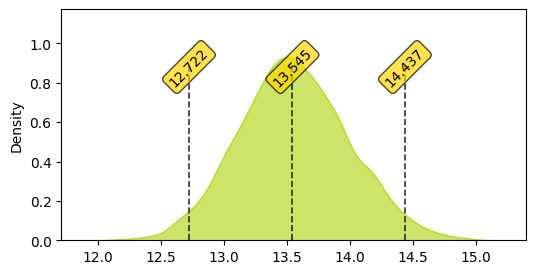

In [197]:
ci_plot(cp.asnumpy(cp_boot_means), [0.025,0.975])

# Diễn giải khoảng tin cậy và những ngộ nhận về nó

Trên thực tế, khái niệm khoảng tin cậy tương đối khó hiểu, và vẫn thường bị diễn giải sai bởi nhiều bạn đồng nghiệp, do đó Nhi xin khép lại bài thực hành bằng nội dung: Diễn giải về KTC như thế nào ?

## Diễn giải KTC

Ta có thể diễn giải KTC theo 3 cách:

+ Cách diễn giải thứ nhất, thông qua giả định về sự lặp lại rất nhiều lần chọn mẫu khác nhau. Thí dụ, nếu mức độ tin cậy là 95% và ta ước lượng được giá trị trung bình của biến số DLCO trong 1 mẫu quan sát hiện tại là 13.55, với KTC 95% là 12.8 – 14.3; gợi ý rằng nếu ta lặp lại ước lượng này nhiều lần trên rất nhiều mẫu khác nhau (thí dụ 1000 mẫu), rồi tính tỉ lệ giữa phần kết quả trong khoảng 12.8 đến 14.3; so với toàn thể, thì tỉ lệ này sẽ rất gần với 0.95

+ Cách diễn giải thứ hai mang ý nghĩa xác suất, và áp dụng cho 1 mẫu khảo sát duy nhất: Với mức độ tin cậy 95%, ta có thể dự đoán rằng khi thực hiện một thí nghiệm tương tự trong **tương lai**, khoảng tin cậy cho mẫu khảo sát **mới** sẽ có xác suất 95% chứa giá trị thực (trung bình quần thể). Thực ra, nội dung này tương đương với cách diễn giải ở trên, tuy nhiên cách diễn giải thứ hai có ý nghĩa hiện thực hơn, vì nó không dựa trên giả định (hư cấu) về thí nghiệm lặp lại vô số lần.

+ Cách diễn giải thứ 3, thông dụng trong văn bản khoa học, nhằm khẳng định về độ **khả tín** của kết quả ước lượng (trung bình mẫu) báo cáo trên mẫu khảo sát hiện thời, so với trung bình thực của quần thể; theo đó nếu dùng độ tin cậy 95%, sự khác biệt giữa giá trị được báo cáo và giá trị thực trong quần thể là không có ý nghĩa thống kê ở ngưỡng 5%. Nói cách khác, việc ngẫu nhiên quan sát được một giá trị khác biệt với giá trị thực của quần thể xa hơn mức độ trong khoảng tin cậy chỉ có xác suất 5% (hoặc thậm chí thấp hơn).

## Những sai lầm và ngộ nhận về KTC

Trong cả 3 cách diễn giải, chúng ta đang suy diễn về tương lai và cho quần thể, chứ không phải hiện tại và cho mẫu khảo sát hiện hành. Và thông số cần ước lượng (thí dụ trung bình, hệ số tương quan, hệ số hồi quy…) vẫn luôn là bất định.

Sai lầm thứ nhất, là diễn giải KTC cho mẫu và hiện tại: Ta không thể phát biểu: có 95% xác suất thông số thực của quần thể sẽ nằm bên trong khoảng tin cậy hiện thời (tương ứng với mẫu/thí nghiệm hiện hành). Vì một khi ước lượng (point estimation) đã thực hiện, kết quả của nó mang ý nghĩa xác định (deterministic), nên chuyện KTC hiện tại có chứa hay không chứa giá trị thực không còn là vấn đề xác suất nữa. 

Sai lầm thứ hai, đó là nhầm lẫn giữa KTC cho 1 thông số thống kê (trung bình, trung vị) và các phân vị của dữ liệu. KTC được áp dụng cho 1 phép ước lượng (thông số thống kê), chứ không phải cho dữ liệu (các giá trị quan sát trong mẫu). Sai lầm này rất phổ biến, thậm chí trong nhiều bài báo khoa học; tác giả đã làm bảng kết quả thống kê mô tả gồm 2 cột, 1 cột trình bày trung vị, cột còn lại được đặt tiêu đề là 95%CI; Điều này hoàn toàn sai: Kết quả mà tác giả đang báo cáo chỉ là 2 bách phân vị thứ 5 và 95 (hay 2.5, 97.5) của dữ liệu, chứ không phải là KTC95% của trung vị. Cần phân biệt khoảng tin cậy và các bách phân vị. 

Chỉ duy nhất trong quy trình bootstrap, 2 khái niệm KTC và bách phân vị mới chồng lắp lên nhau, vì ta đang khảo sát chuỗi dữ liệu của chính thông số mục tiêu (trung bình).

Khi làm thống kê mô tả đặc tính phân bố của một biến số liên tục, ta có thể báo cáo Trung bình hoặc trung vị, kèm theo (bách phân vị 5 và 95), nhưng không nên nhầm lẫn giữa 2 con số trong ngoặc này là KTC 95% của giá trị trung bình/trung vị.

Sai lầm thứ ba, khi cho rằng KTC là duy nhất : Không có khoảng tin cậy xác định và duy nhất, KTC cũng bất định như thông số mục tiêu, mỗi mẫu khảo sát sẽ tương ứng với một KTC, nhưng giá trị KTC sẽ thay đổi trên một mẫu khác. KTC được suy diễn cho thông số ước lượng của quần thể, không phải của mẫu.

Ngộ nhận cuối cùng, khá tế nhị, đó là khi phát biểu về sự lặp lại nhiều lần 1 thí nghiệm trên cùng một mẫu khảo sát. Như ta đã nói ở trên, KTC dùng để suy diễn cho thông số thực của quần thể, không phải cho thông số của 1 mẫu xác định. Rất nhiều yếu tố, điều kiện có thể thay đổi trong một thí nghiệm. Ta không thể nói: có 95% khả năng là thông số ước lượng từ 100 lần thí nghiệm khác nhau lặp lại trên cùng một mẫu sẽ rơi vào trong KTC 95% của kết quả trong lần thí nghiệm đầu tiên. 

# Tổng kết

Để kết thúc, Nhi xin tóm tắt những thông điệp chính trong bài:

+ Khoảng tin cậy áp dụng cho một phép ước lượng, một thông số thống kê, nó cho phép hình dung về khả năng suy diễn về giá trị thực của thông số đó trong quần thể.

+ Kỹ thuật Bootstrap làm cho việc ước lượng khoảng tin cậy trở nên khả thi, thậm chí dễ dàng; chỉ cần 1 mẫu khảo sát hiện thời, không cần phải lặp lại việc chọn mẫu trên thực tế.

+ Ước lượng phân vị là một trong nhiều cách để xác định khoảng tin cậy trong quy trình Bootstrap. Ta có thể triển khai quy trình ước lượng phân vị bằng nhiều cách, như code thủ công, sử dụng thư viện chạy trên CPU và GPU.

+ Có thể thực hiện quy trình bootstrap hoàn toàn trên GPU

+ Cần cẩn trọng khi diễn giải ý nghĩa KTC, tránh những ngộ nhận. Đặc biệt nguy hiểm là nhầm lẫn về thuật ngữ KTC của một thông số như trung bình/trung vị và các phân vị của dữ liệu trong mẫu.

Bài thực hành đến đây là hết. Chúc các bạn thực hành vui.